In [1]:
import numpy as np
import math

import astropy.units as u
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris

from poliastro.bodies import Sun,Venus, Earth, Jupiter, Saturn
from poliastro.threebody import flybys
from poliastro.twobody import Orbit
from poliastro.maneuver import Maneuver
from poliastro.iod import izzo
from poliastro.plotting import OrbitPlotter2D
from poliastro.util import norm
import poliastro.twobody.propagation as Propagation

from scipy import optimize as opt
 
solar_system_ephemeris.set("jpl")

<ScienceState solar_system_ephemeris: 'jpl'>

In [2]:
T = 5*30*u.day;
a_at_saturn=((T**2*Saturn.k/(4*math.pi**2))**(1/3)).to(u.m)

In [3]:
cassini_venus2 = Time("1999-06-24")
cassini_earth2 = Time("1999-08-18")
cassini_jupiter = Time("2000-12-30")
cassini_saturn = Time("2004-07-01")

#cassini transit
cassini_js_time = cassini_saturn-cassini_jupiter
cassini_ej_time = cassini_jupiter-cassini_earth2
cassini_ve_time = cassini_earth2-cassini_venus2

In [4]:
tmod=[0,0,0,0]
plot_on=0;

def trajectory_calculator(t=[0,0,0,0],plot_on=0,disp_on=0):
    #start with cassini style assumptions
    cassini_venus2 = Time("1999-06-24")
    cassini_earth2 = Time("1999-08-18")
    cassini_jupiter = Time("2000-12-30")
    cassini_saturn = Time("2004-07-01")

    #cassini transit
    cassini_js_time = cassini_saturn-cassini_jupiter
    cassini_ej_time = cassini_jupiter-cassini_earth2
    cassini_ve_time = cassini_earth2-cassini_venus2


    tmod_s  = t[0] #arrival time in saturn relative to 2020
    tmod_js = t[1] #transit times
    tmod_ej = t[2] 
    tmod_ve = t[3]


    time_js = tmod_js*u.year
    time_ej = tmod_ej*u.year
    time_ve = tmod_ve*u.year

    date_arrive_saturn = Time("2020-01-01", scale="tdb")+tmod_s*u.year;


    #create target orbit
    o_sf = Orbit.from_body_ephem(Saturn, date_arrive_saturn)
    r_sf, v_sf = o_sf.rv()
    #o_sf.plot()
    if disp_on:
        print('computed saturn')

    ################## Jupiter ################## 

    #guess flyby date of Jupiter
    date_flyby_jupiter = date_arrive_saturn-time_js

    #construct j orbit
    o_j = Orbit.from_body_ephem(Jupiter, date_flyby_jupiter)
    #o_j.plot()

    #compute transfer lambert trajectory
    (v_jo, v_si), = izzo.lambert(Sun.k, o_j.r, o_sf.r, time_js)
    trx_js = Orbit.from_vectors(Sun, o_j.r, v_jo, epoch=date_flyby_jupiter)
    #trx_js.plot()
    if disp_on:
        print('computed J-S')
    ################## Earth ################## 
    #guess flyby date of Earth
    date_flyby_earth = date_arrive_saturn-time_js-time_ej

    #construct j orbit
    o_e2 = Orbit.from_body_ephem(Earth, date_flyby_earth)
    #o_e2.plot()

    #compute transfer lambert trajectory
    (v_eo, v_ji), = izzo.lambert(Sun.k, o_e2.r, o_j.r, time_ej)
    trx_ej = Orbit.from_vectors(Sun, o_e2.r, v_eo, epoch=date_flyby_earth)
    #trx_ej.plot()
    if disp_on:
        print('computed E-J')                            

    ################## Venus2 ################## 
    #guess flyby date of Venus2
    date_flyby_venus2 = date_arrive_saturn-time_js-time_ej-time_ve

    #construct j orbit
    o_v2 = Orbit.from_body_ephem(Venus, date_flyby_venus2)
    #o_v2.plot()

    #compute transfer lambert trajectory
    (v_v2o, v_ei), = izzo.lambert(Sun.k, o_v2.r, o_e2.r, time_ve)
    trx_v2e = Orbit.from_vectors(Sun, o_v2.r, v_v2o, epoch=date_flyby_venus2)
    #trx_v2e.plot()    
    if disp_on:
        print('computed V-E')                            

    ################## Sum delta v ##################                             
    delv_e = norm(v_eo-v_ei)
    delv_j = norm(v_jo-v_ji)
    delv_s = norm(v_si-v_sf)

    total_deltav=sum([delv_e,delv_j,delv_s]) 

    if disp_on:
        print('Total delta-v: ', total_deltav)

    ################## Plot ##################  

    if plot_on:
        op = OrbitPlotter2D()

        op.plot(o_v2,label="Venus2 Orbit")
        op.plot(o_e2,label="Earth2 Orbit")
        op.plot(o_j, label="Jupiter Orbit")
        op.plot(o_sf, label="Saturn Orbit")


        op.plot(trx_v2e, label="V2-E")
        op.plot(trx_ej, label="E-J")
        op.plot(trx_js, label="J-S")
        
    orbits = (o_v2,o_e2,o_j,o_sf)
    trajectories = (trx_v2e,trx_ej,trx_js)
    deltavs = (delv_e,delv_j,delv_s)
    times = (date_flyby_venus2,date_flyby_earth,date_flyby_jupiter,date_arrive_saturn)
    return (total_deltav,orbits,trajectories,deltavs,times)

def print_times(times):
    print("Venus:   ",times[0])
    print("Earth:   ",times[1])
    print("Jupiter: ",times[2])
    print("Saturn:  ",times[3])
    print("**")
    print("V-E: ", (times[1]-times[0]).to(u.year))
    print("E-J: ", (times[2]-times[1]).to(u.year))
    print("J-S: ", (times[3]-times[2]).to(u.year))
        



In [5]:
t_guess_cassini = [27,cassini_js_time.to(u.year).value,cassini_ej_time.to(u.year).value,cassini_ve_time.to(u.year).value]
sol=trajectory_calculator(t=t_guess_cassini,plot_on=0,disp_on=1)

computed saturn
computed J-S
computed E-J
computed V-E
Total delta-v:  82.09823281566118 km / s


In [6]:
###############VERY GOOD SOLUTION############
tverygood = [27.238877,4.798,1.2879,0.1313]
sol=trajectory_calculator(t=tverygood,plot_on=0,disp_on=1)

computed saturn
computed J-S
computed E-J
computed V-E
Total delta-v:  6.010065391517322 km / s


In [27]:
t_guess_cassini = [-15.5,cassini_js_time.to(u.year).value,cassini_ej_time.to(u.year).value,cassini_ve_time.to(u.year).value]

t_guess_online_traj_tool = [20, 7.93, 2.19,0.15]
t_guess_online_traj_tool = [12, 2, 2,0.15]


#t_guess = opt_sol.x

t_guess=tverygood

tdept = 26;
t_ve  = 28/365;
t_ej  = 491/365;
t_js  = 1304/365

t_guess = [tdept+t_ve+t_ej+t_js, t_js, t_ej, t_ve]

t_guess=tverygood



t_guess = [15,5,2,0.3]

#t_guess=t_guess_online_traj_tool

bounds = ((5,25),(1,10),(0.5,3),(0.01,1))
#bounds = ((30,36),(None,None),(None,None),(None, None))

options = {'maxiter': 50,'disp': False}

penalty = 10;


def calc_max_deltav(v_inf,qratio=10, body=Earth):
    return 2*v_inf*(1+((v_inf)**2*(qratio*body.R)/(body.k)).to(u.m/u.m))**-1

def saturn_deltav_calculator(tmod):
    print(tmod)
    sol=trajectory_calculator(tmod,plot_on=0,disp_on=0)
    print(sol[3])

    return sol[3][2].to(u.km/u.s).value


def weighted_detlav_calculator(tmod):
    
    global penalty
    #print(tmod)
    sol=trajectory_calculator(tmod,plot_on=0,disp_on=0)
    
    #determine venus vinf
    
    o_v = sol[1][0]
    o_e = sol[1][1]
    o_j = sol[1][2]
    o_s = sol[1][3]


    trx_ve = sol[2][0]
    trx_ej = sol[2][1]
    trx_js = sol[2][2]

    vinf_v = norm(trx_ve.v-o_v.v).to(u.km/u.s)
    vinf_e = norm(trx_ej.v-o_e.v).to(u.km/u.s)
    vinf_j = norm(trx_js.v-o_j.v).to(u.km/u.s)
    vinf_s = sol[3][2].to(u.km/u.s)

    q_min_v = Venus.R   +  500*u.km;
    q_min_e = Earth.R   + 1500*u.km;
    q_min_j = Jupiter.R + 1500*u.km;

    maxdv_v = 2*vinf_v/(1+vinf_v**2*q_min_v/Venus.k)
    maxdv_e = 2*vinf_e/(1+vinf_e**2*q_min_e/Earth.k)
    maxdv_j = 2*vinf_j/(1+vinf_v**2*q_min_j/Jupiter.k)
    
    dv_e = sol[3][0];
    dv_j = sol[3][1];
    
    mainfunc = vinf_v.to(u.km/u.s).value
    
    if(maxdv_e-dv_e>0):
        e_constraint = penalty*((maxdv_e-dv_e).to(u.km/u.s).value)
    else:
        e_constraint =  0
        
    if(maxdv_j-dv_j>0):
        j_constraint = penalty*((maxdv_j-dv_j).to(u.km/u.s).value)
    else:
        j_constraint =  0
        
    if(5*u.km/u.s-vinf_s>0):
        s_constraint = penalty*((5*u.km/u.s-vinf_s).to(u.km/u.s).value)
    else:
        s_constraint =  0
        
    penalty=penalty*1.02;

    return mainfunc # + mu*(e_constraint+j_constraint+s_constraint)

def saturnVinfConstraint(ts):
    sol=trajectory_calculator(ts,plot_on=0,disp_on=0)
    
    vinf_s = sol[3][2].to(u.km/u.s).value
    
    return 5-vinf_s
    

def earthflybyConstraint(ts):
    sol=trajectory_calculator(ts,plot_on=0,disp_on=0)
    
    o_v = sol[1][0]
    o_e = sol[1][1]
    o_j = sol[1][2]
    o_s = sol[1][3]

    trx_ej = sol[2][1]    
    
    deltav_e = sol[3][0]
    
    vinf_e = norm(trx_ej.v-o_e.v).to(u.km/u.s)

    q_min_e = Earth.R   + 1500*u.km;
    
    maxdv_e = 2*vinf_e/(1+vinf_e**2*q_min_e/Earth.k)
    
    return maxdv_e-1.05*deltav_e

def jupiterflybyConstraint(ts):
    sol=trajectory_calculator(ts,plot_on=0,disp_on=0)
    
    o_v = sol[1][0]
    o_e = sol[1][1]
    o_j = sol[1][2]
    o_s = sol[1][3]


    trx_ve = sol[2][0]
    trx_ej = sol[2][1]
    trx_js = sol[2][2]
    
    deltav_j = sol[3][1]
    
    vinf_j = norm(trx_js.v-o_j.v).to(u.km/u.s)

    q_min_j = Jupiter.R + 1500*u.km;

    maxdv_j = 2*vinf_j/(1+vinf_j**2*q_min_j/Jupiter.k)
    
    return maxdv_j-1.05*deltav_j
    
earth_constraint ={'type':'ineq','fun':earthflybyConstraint}
jupiter_constraint ={'type':'ineq','fun':jupiterflybyConstraint}
saturn_constraint = {'type': 'ineq','fun':saturnVinfConstraint}

constraints = (earth_constraint,jupiter_constraint,saturn_constraint)

opt_sol = opt.minimize(weighted_detlav_calculator,x0=t_guess,options=options,method='SLSQP',bounds=bounds,constraints=constraints);
#opt_sol = opt.differential_evolution(weighted_detlav_calculator, bounds=bounds,disp = True,maxiter=100)

In [30]:
penalty


40932.86470511943

In [31]:
opt_sol

     fun: 23.77220669568198
     jac: array([ -10.69735074,   10.6973629 ,   10.6973629 , -146.41417527])
 message: 'Iteration limit exceeded'
    nfev: 420
     nit: 51
    njev: 51
  status: 9
 success: False
       x: array([ 16.55105406,   6.51940206,   1.93529364,   0.21691674])

In [39]:
sol = trajectory_calculator(t=opt_sol.x,plot_on=0,disp_on=1)

print(opt_sol)

#sol = trajectory_calculator([ 21.82450945,   9.33104326,   2.39418937,   0.2])

#print("Tmod: ",opt_sol.x)
print()
print("Total deltav: ", sol[0])
print("Delta vs: ",[x.value for x in sol[3]])
print()



t_ve=sol[4][1]-sol[4][0]
t_ej=sol[4][2]-sol[4][1]
t_js=sol[4][3]-sol[4][2]

o_v = sol[1][0]
o_e = sol[1][1]
o_j = sol[1][2]
o_s = sol[1][3]


trx_ve = sol[2][0]
trx_ej = sol[2][1]
trx_js = sol[2][2]


trx_ve_half = trx_ve.propagate(t_ve/2)
trx_ej_half = trx_ej.propagate(t_ej/2)
trx_js_half = trx_js.propagate(t_js/2)

vinf_v = norm(trx_ve.v-o_v.v).to(u.km/u.s)
vinf_e = norm(trx_ej.v-o_e.v).to(u.km/u.s)
vinf_j = norm(trx_js.v-o_j.v).to(u.km/u.s)

print('vinf_v = ',vinf_v)
print('vinf_e = ',vinf_e)
print('vinf_j = ',vinf_j)

q_min_v = Venus.R   + 500*u.km;
q_min_e = Earth.R   + 1500*u.km;
q_min_j = Jupiter.R + 1500*u.km;

maxdv_v = 2*vinf_v/(1+vinf_v**2*q_min_v/Venus.k)
maxdv_e = 2*vinf_e/(1+vinf_e**2*q_min_e/Earth.k)
maxdv_j = 2*vinf_j/(1+vinf_j**2*q_min_j/Jupiter.k)

print('maxdv_v: ', maxdv_v)
print('maxdv_e: ', maxdv_e)
print('maxdv_j: ', maxdv_j)

print('dv_v: ')
print('dv_e: ', sol[3][0] )
print('dv_j: ', sol[3][1] )

print()
print('errors:')

if sol[3][0] > maxdv_e:
    print('cant flyby earth')
if sol[3][1] > maxdv_j:
    print('cant flyby jupiter')
if sol[3][2] > 5000*u.m/u.s:
    print('cant slow down saturn')

print()

print('Times:')
print_times(sol[4])
print()



computed saturn
computed J-S
computed E-J
computed V-E
Total delta-v:  24.955105743117485 km / s
     fun: 23.77220669568198
     jac: array([ -10.69735074,   10.6973629 ,   10.6973629 , -146.41417527])
 message: 'Iteration limit exceeded'
    nfev: 420
     nit: 51
    njev: 51
  status: 9
 success: False
       x: array([ 16.55105406,   6.51940206,   1.93529364,   0.21691674])

Total deltav:  24.955105743117485 km / s
Delta vs:  [6.57151967535984, 13.229016105144458, 5.15456996261319]

vinf_v =  23.77220669568198 km / s
vinf_e =  23.009609900420696 km / s
vinf_j =  8.74735375348701 km / s
maxdv_v:  3.835035234832381 km / s
maxdv_e:  4.857880821178321 km / s
maxdv_j:  16.756152919626768 km / s
dv_v: 
dv_e:  6.57151967535984 km / s
dv_j:  13.229016105144458 km / s

errors:
cant flyby earth
cant slow down saturn

Times:
Venus:    2027-11-17 23:11:06.939
Earth:    2028-02-05 04:40:38.509
Jupiter:  2030-01-12 01:27:41.048
Saturn:   2036-07-20 06:32:23.473
**
V-E:  0.2169167354237251 yr
E-

In [34]:
op=OrbitPlotter2D()
op.plot(sol[1][0],label='V')
op.plot(sol[1][1],label='E')
op.plot(sol[1][2],label='J')
op.plot(sol[1][3],label='S')
op.plot(trx_ve_half,label='VE')
op.plot(trx_ej_half,label='EJ')
op.plot(trx_js_half,label='JS')

/Users/Devansh/anaconda3/lib/python3.6/site-packages/poliastro/twobody/propagation.py:232: UserWarning:

Frame <class 'astropy.coordinates.builtin_frames.icrs.ICRS'> does not support 'obstime', time values were not returned



FigureWidget({
    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(31, 119, 180)', 'dash':…

In [34]:
#venus to earth transfer orbit params at start
print('frame: ',trx_ve.frame)
print('epoch:',trx_ve.epoch)
print('GMAT ELDER.Epoch =',(trx_ve.epoch-Time("1941-01-05")).value, ';')
print('GMAT ELDER.SMA =  ', trx_ve.p.to(u.km).value,';')
print('GMAT ELDER.ECC =  ', trx_ve.ecc.value,';')
print('GMAT ELDER.INC =  ', trx_ve.inc.to(u.deg).value,';')
print('GMAT ELDER.RAAN = ', trx_ve.raan.to(u.deg).value,';')
print('GMAT ELDER.AOP =  ',trx_ve.argp.to(u.deg).value,';')
print('GMAT ELDER.TA =   ', trx_ve.nu.to(u.deg).value,';')

frame:  <HCRS Frame (obstime=2027-11-18 01:18)>
epoch: 2027-11-18 01:18
GMAT ELDER.Epoch = 31728.054273902144 ;
GMAT ELDER.SMA =   111181845.08052635 ;
GMAT ELDER.ECC =   0.6711225483921878 ;
GMAT ELDER.INC =   28.25439130325728 ;
GMAT ELDER.RAAN =  350.71186922680675 ;
GMAT ELDER.AOP =   32.73630435246714 ;
GMAT ELDER.TA =    -88.63087288054484 ;


In [35]:
t_very_good=[29.13542901,  11.23456831,   2.51874946,   4.99999999]
t_very_good2 = [27.27073206,  12.20395588,   2.94564204,   3.14643358]
sol = trajectory_calculator(t=t_very_good2,plot_on=0,disp_on=1)

print(opt_sol)

#sol = trajectory_calculator([ 21.82450945,   9.33104326,   2.39418937,   0.2])

#print("Tmod: ",opt_sol.x)
print()
print("Total deltav: ", sol[0])
print("Delta vs: ",[x.value for x in sol[3]])
print()



t_ve=sol[4][1]-sol[4][0]
t_ej=sol[4][2]-sol[4][1]
t_js=sol[4][3]-sol[4][2]

o_v = sol[1][0]
o_e = sol[1][1]
o_j = sol[1][2]
o_s = sol[1][3]


trx_ve = sol[2][0]
trx_ej = sol[2][1]
trx_js = sol[2][2]


trx_ve_half = trx_ve.propagate(t_ve/2)
trx_ej_half = trx_ej.propagate(t_ej/2)
trx_js_half = trx_js.propagate(t_js/2)

vinf_v = norm(trx_ve.v-o_v.v).to(u.km/u.s)
vinf_e = norm(trx_ej.v-o_e.v).to(u.km/u.s)
vinf_j = norm(trx_js.v-o_j.v).to(u.km/u.s)

print('vinf_v = ',vinf_v)
print('vinf_e = ',vinf_e)
print('vinf_j = ',vinf_j)

q_min_v = Venus.R   + 500*u.km;
q_min_e = Earth.R   + 1500*u.km;
q_min_j = Jupiter.R + 1500*u.km;

maxdv_v = 2*vinf_v/(1+vinf_v**2*q_min_v/Venus.k)
maxdv_e = 2*vinf_e/(1+vinf_e**2*q_min_e/Earth.k)
maxdv_j = 2*vinf_j/(1+vinf_v**2*q_min_j/Jupiter.k)

print('maxdv_v: ', maxdv_v)
print('maxdv_e: ', maxdv_e)
print('maxdv_j: ', maxdv_j)

print('dv_v: ')
print('dv_e: ', sol[3][0] )
print('dv_j: ', sol[3][1] )

print()
print('errors:')

if sol[3][0] > maxdv_e:
    print('cant flyby earth')
if sol[3][1] > maxdv_j:
    print('cant flyby jupiter')
if sol[3][2] > 700*u.m/u.s:
    print('cant slow down saturn')

print()

print('Times:')
print_times(sol[4])
print()

computed saturn
computed J-S
computed E-J
computed V-E
Total delta-v:  15.266531561730773 km / s
     fun: 23.771332632636334
     jac: array([ -10.5844481 ,   10.58445144,   10.58445144, -146.67745423])
 message: 'Iteration limit exceeded'
    nfev: 395
     nit: 51
    njev: 51
  status: 9
 success: False
       x: array([ 16.54967045,   6.51875798,   1.93432242,   0.21690588])

Total deltav:  15.266531561730773 km / s
Delta vs:  [5.296411656941787, 7.857778023134297, 2.1123418816546895]

vinf_v =  10.516369423383471 km / s
vinf_e =  14.770401693194467 km / s
vinf_j =  4.4628607506713625 km / s
maxdv_v:  6.510720372376563 km / s
maxdv_e:  5.561232614211904 km / s
maxdv_j:  8.391147391503536 km / s
dv_v: 
dv_e:  5.296411656941787 km / s
dv_j:  7.857778023134297 km / s

errors:
cant slow down saturn

Times:
Venus:    2028-12-22 00:13:30.392
Earth:    2032-02-14 05:51:42.736
Jupiter:  2035-01-25 03:21:35.978
Saturn:   2047-04-09 15:14:14.057
**
V-E:  3.14643358 yr
E-J:  2.94564204 yr
J-

In [93]:
op=OrbitPlotter2D()
op.plot(sol[1][0],label='V')
op.plot(sol[1][1],label='E')
op.plot(sol[1][2],label='J')
op.plot(sol[1][3],label='S')
op.plot(trx_ve_half,label='VE')
op.plot(trx_ej_half,label='EJ')
op.plot(trx_js_half,label='JS')

/Users/Devansh/anaconda3/lib/python3.6/site-packages/poliastro/twobody/propagation.py:232: UserWarning:

Frame <class 'astropy.coordinates.builtin_frames.icrs.ICRS'> does not support 'obstime', time values were not returned



FigureWidget({
    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(31, 119, 180)', 'dash':…

In [ ]:
v_vec=[trx_ve.v[0],trx_ve.v[1]]

In [ ]:
trx_ve.r.to(u.AU)

In [ ]:
r_vec=[trx_ve.r[0],trx_ve.r[1]]

In [ ]:
trx_ve.r

In [ ]:
v_radial

In [ ]:
norm(v_radial)

In [ ]:
v_tangetial

In [ ]:
norm(v_tangetial)

In [ ]:
norm(o_v.v).to(u.km/u.s)

In [ ]:
norm(trx_ve.v-o_v.v)

In [ ]:
norm(vinf_v)

In [ ]:
deltav_max

In [ ]:
q_min

In [ ]:
Venus.k

In [ ]:
trx_js_final = trx_js.propagate(t_js)

In [ ]:
trx_js_final.v

In [ ]:
o_s=sol[1][3]

In [ ]:
o_s.v.to(u.km/u.s)

In [ ]:
norm(trx_js_final.v-o_s.v)

In [ ]:
(Saturn.k/(4*Saturn.R))**0.5

In [ ]:
print()
print("Total deltav: ", sol[0])
print("Delta vs: ",[x.value for x in sol[3]])
print()


In [ ]:
earthflybyConstraint(opt_sol.x)
print('jup')
jupiterflybyConstraint(opt_sol.x)

In [ ]:

o_v

In [ ]:
earth_departure_time

In [ ]:
venus_arrival_time = o_v.epoch
earth_departure_time = venus_arrival_time - 1.450846798*u.year
o_e_launch = Orbit.from_body_ephem(Earth,earth_departure_time)
o_v_launch = Orbit.from_body_ephem(Venus,earth_departure_time)
print((180/math.pi)*math.acos(np.dot(o_e_launch.r.to(u.km).value,o_v.r.to(u.km).value)/(norm(o_e_launch.r.to(u.km)).value*norm(o_v.r.to(u.km)).value)))
op=OrbitPlotter2D()
op.plot(o_e_launch)
op.plot(o_v)

In [ ]:
o_e_launch

In [ ]:
op=OrbitPlotter2D()
op.plot(o_e_launch)
op.plot(o_v_launch)
op.plot(o_v)

In [ ]:
o_e_launch.r

In [ ]:
o_v.r

In [ ]:
np.dot(o_e_launch.r.to(u.km).value,o_v.r.to(u.km).value)

In [ ]:
np.dot(o_e_launch.r.to(u.km).value,o_v.r.to(u.km).value)

In [ ]:
norm(o_e_launch.r.to(u.km)).value

In [42]:
from poliastro.plotting.porkchop import porkchop
from poliastro.util import time_range


TypeError: unsupported operand type(s) for *: 'numpy.ndarray' and 'PrefixUnit'

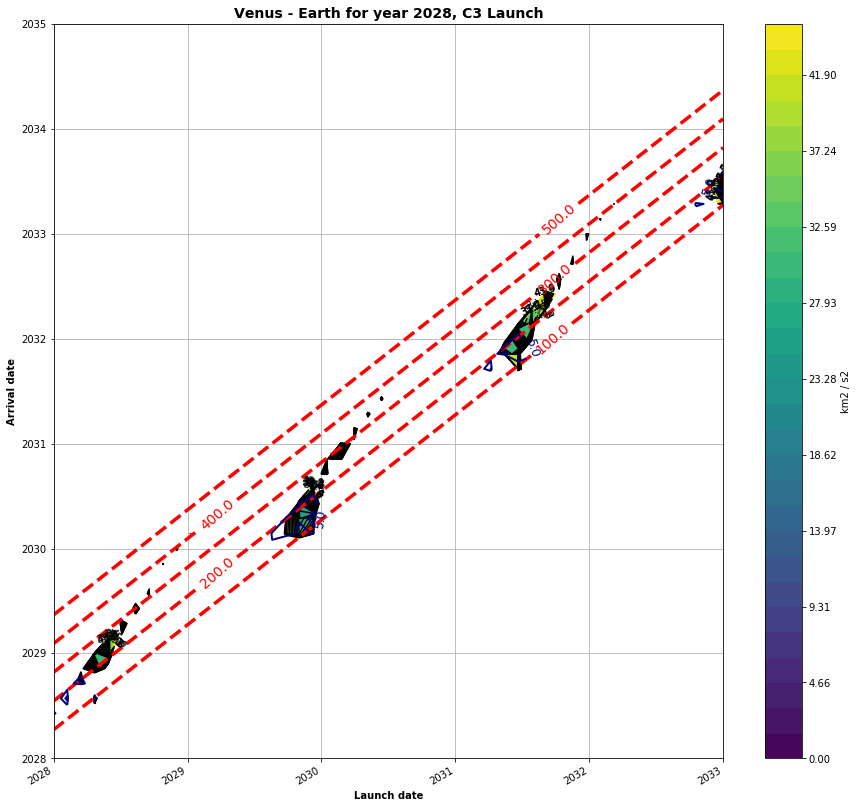

In [47]:
V_span = time_range("2028-01-01", end="2033-01-01")
E_span = time_range("2028-01-01", end="2035-01-01")
c3dpt, c3arr, tof = porkchop(Venus, Earth, V_span, E_span)

/Users/Devansh/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning:

No contour levels were found within the data range.



ValueError: too many values to unpack (expected 3)

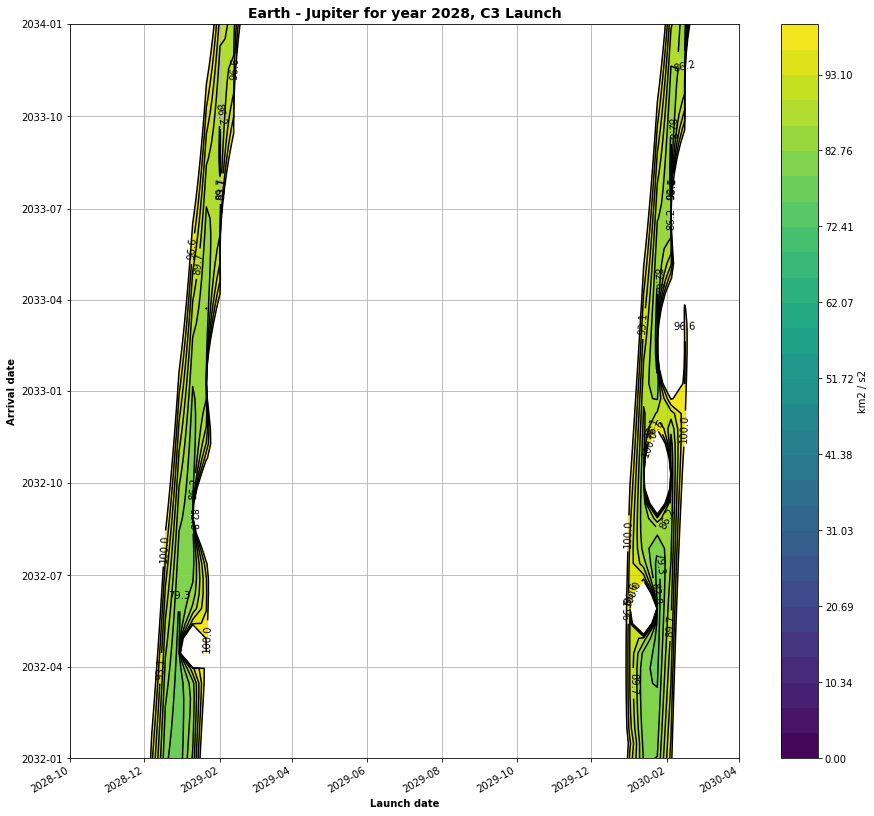

In [64]:
V_span = time_range("2028-01-01", end="2029-01-01")
E_span = time_range("2028-10-01", end="2030-04-01")
J_span = time_range("2032-01-01", end="2034-01-01")
c3dpt, c3arr, tof = porkchop(Earth, Jupiter, E_span, J_span,max_c3=100*u.km*u.km / (u.s)**2)

TypeError: unsupported operand type(s) for *: 'numpy.ndarray' and 'PrefixUnit'

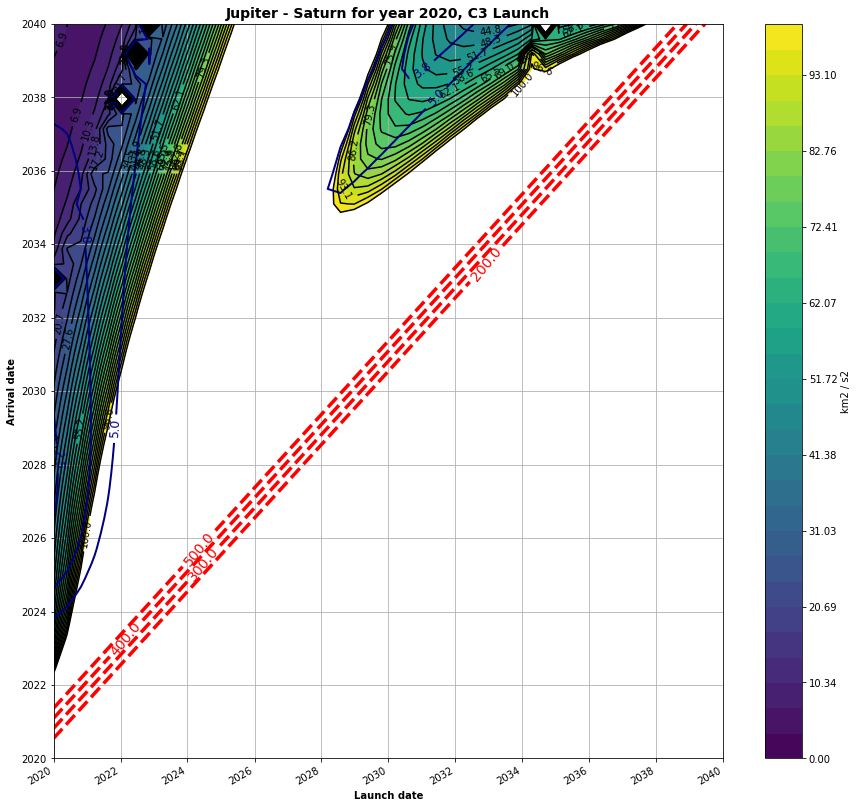

In [66]:
V_span = time_range("2028-01-01", end="2029-01-01")
E_span = time_range("2028-01-01", end="2035-01-01")
J_span = time_range("2020-01-01", end="2040-01-01")
S_span = time_range("2020-01-01", end="2040-01-01")
c3dpt, c3arr, tof = porkchop(Jupiter,Saturn,  J_span, S_span, max_c3=100*u.km*u.km / (u.s)**2)

/Users/Devansh/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning:

No contour levels were found within the data range.



ValueError: too many values to unpack (expected 3)

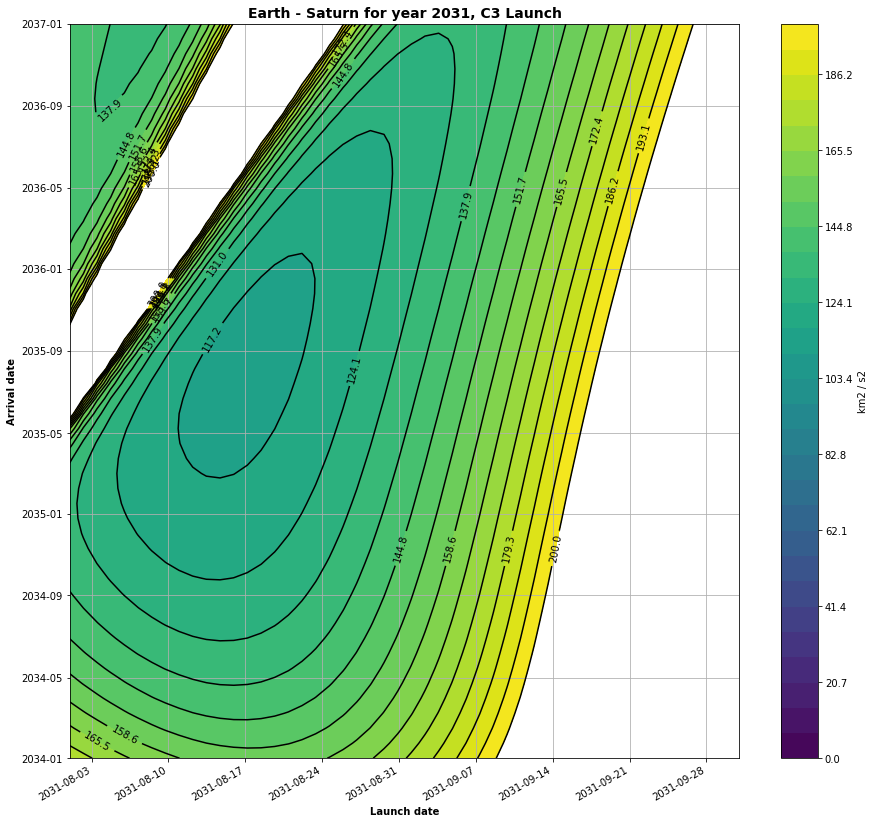

In [79]:
V_span = time_range("2028-01-01", end="2029-01-01")
E_span = time_range("2031-08-01", end="2031-10-01")
J_span = time_range("2020-01-01", end="2035-01-01")
S_span = time_range("2034-01-01", end="2037-01-01")
c3dpt, c3arr, tof = porkchop(Earth,Saturn,  E_span, S_span, max_c3=200*u.km*u.km / (u.s)**2)

TypeError: unsupported operand type(s) for *: 'numpy.ndarray' and 'PrefixUnit'

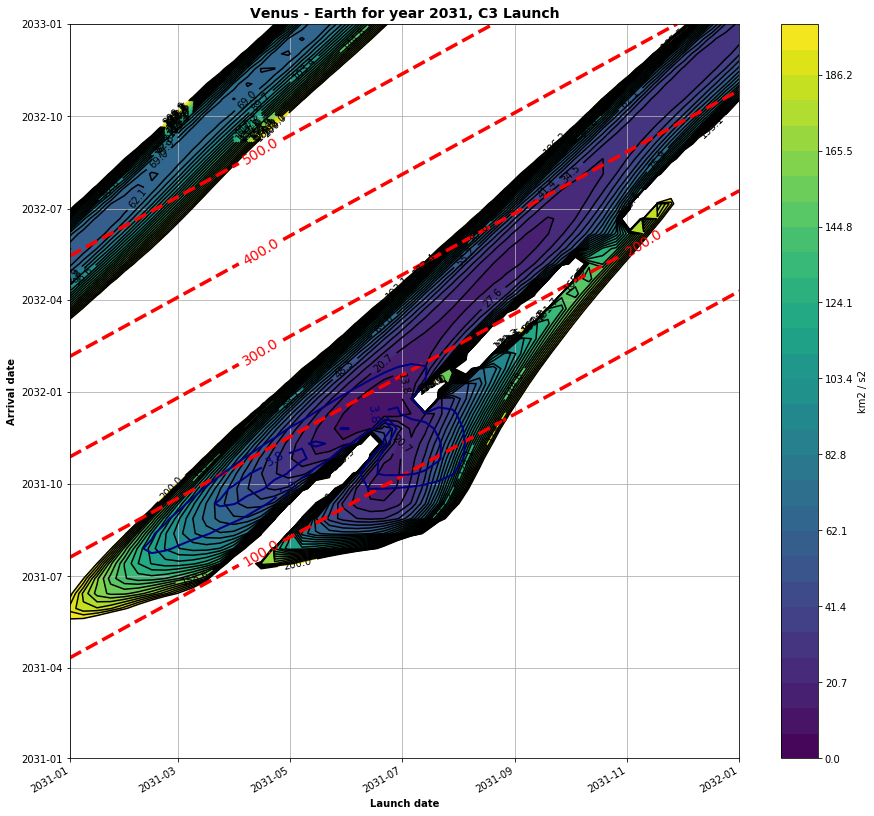

In [77]:
V_span = time_range("2031-01-01", end="2032-01-01")
E_span = time_range("2031-01-01", end="2033-01-01")

c3dpt, c3arr, tof = porkchop(Venus,Earth,  V_span, E_span, max_c3=200*u.km*u.km / (u.s)**2)

In [84]:
tmod=[0,0,0,0]
plot_on=0;

def VES_trajectory_calculator(t=[0,0,0],plot_on=0,disp_on=0):

    tmod_s  = t[0] #arrival time in saturn relative to 2020
    tmod_es = t[1] 
    tmod_ve = t[2]

    time_es = tmod_es*u.year
    time_ve = tmod_ve*u.year

    date_arrive_saturn = Time("2020-01-01", scale="tdb")+tmod_s*u.year;


    #create target orbit
    o_sf = Orbit.from_body_ephem(Saturn, date_arrive_saturn)
    r_sf, v_sf = o_sf.rv()
    #o_sf.plot()
    if disp_on:
        print('computed saturn')

    ################## Earth ################## 
    #guess flyby date of Earth
    date_flyby_earth = date_arrive_saturn-time_es

    #construct e orbit
    o_e2 = Orbit.from_body_ephem(Earth, date_flyby_earth)
    #o_e2.plot()

    #compute transfer lambert trajectory
    (v_eo, v_si), = izzo.lambert(Sun.k, o_e2.r, o_sf.r, time_es)
    trx_es = Orbit.from_vectors(Sun, o_e2.r, v_eo, epoch=date_flyby_earth)
    #trx_ej.plot()
    if disp_on:
        print('computed E-J')                            

    ################## Venus2 ################## 
    #guess flyby date of Venus2
    date_flyby_venus2 = date_arrive_saturn-time_es-time_ve

    #construct j orbit
    o_v2 = Orbit.from_body_ephem(Venus, date_flyby_venus2)
    #o_v2.plot()

    #compute transfer lambert trajectory
    (v_v2o, v_ei), = izzo.lambert(Sun.k, o_v2.r, o_e2.r, time_ve)
    trx_v2e = Orbit.from_vectors(Sun, o_v2.r, v_v2o, epoch=date_flyby_venus2)
    #trx_v2e.plot()    
    if disp_on:
        print('computed V-E')                            

    ################## Sum delta v ##################                             
    delv_e = norm(v_eo-v_ei)
    delv_s = norm(v_si-v_sf)

    total_deltav=sum([delv_e,delv_s]) 

    if disp_on:
        print('Total delta-v: ', total_deltav)

    ################## Plot ##################  

    if plot_on:
        op = OrbitPlotter2D()

        op.plot(o_v2,label="Venus2 Orbit")
        op.plot(o_e2,label="Earth2 Orbit")
        op.plot(o_sf, label="Saturn Orbit")


        op.plot(trx_v2e, label="V2-E")
        op.plot(trx_es, label="E-S")
        
    orbits = (o_v2,o_e2,o_sf)
    trajectories = (trx_v2e,trx_es)
    deltavs = (delv_e,delv_s)
    times = (date_flyby_venus2,date_flyby_earth,date_arrive_saturn)
    return (total_deltav,orbits,trajectories,deltavs,times)

In [86]:
sol=VES_trajectory_calculator(t=[15.75,4+0.5/12,2/12])

In [87]:
sol

(<Quantity 19.16999246175892 km / s>,
 (1 x 1 AU x 24.4 deg (ICRS) orbit around Sun (☉) at epoch 2031-07-17 14:15:00.000 (TDB),
  1 x 1 AU x 23.4 deg (ICRS) orbit around Sun (☉) at epoch 2031-09-16 11:15:00.000 (TDB),
  9 x 10 AU x 22.6 deg (ICRS) orbit around Sun (☉) at epoch 2035-10-01 16:30:00.000 (TDB)),
 (1 x 1 AU x 24.8 deg (HCRS) orbit around Sun (☉) at epoch 2031-07-17 14:15:00.000 (TDB),
  1 x 10 AU x 24.5 deg (HCRS) orbit around Sun (☉) at epoch 2031-09-16 11:15:00.000 (TDB)),
 (<Quantity 12.42483185214815 km / s>, <Quantity 6.745160609610768 km / s>),
 (<Time object: scale='tdb' format='iso' value=2031-07-17 14:15:00.000>,
  <Time object: scale='tdb' format='iso' value=2031-09-16 11:15:00.000>,
  <Time object: scale='tdb' format='iso' value=2035-10-01 16:30:00.000>))

In [96]:
dvs=sol[3]
vinf_v = sol[1][0].v-sol[2][0].v
print('vinf_v = ', norm(vinf_v).to(u.km/u.s))
print('dv_e   = ', (dvs[0]).to(u.km/u.s))
print('vinf_s = ', dvs[1].to(u.km/u.s))
op=OrbitPlotter2D()
op.plot(sol[1][0])
op.plot(sol[1][1])
op.plot(sol[1][2])
op.plot(sol[2][0])
op.plot(sol[2][1])

vinf_v =  8.024991326664985 km / s
dv_e   =  12.42483185214815 km / s
vinf_s =  6.745160609610768 km / s


/Users/Devansh/anaconda3/lib/python3.6/site-packages/poliastro/twobody/propagation.py:232: UserWarning:

Frame <class 'astropy.coordinates.builtin_frames.icrs.ICRS'> does not support 'obstime', time values were not returned



FigureWidget({
    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(31, 119, 180)', 'dash':…

In [144]:
def VES_calc(ts):
    
    sol=VES_trajectory_calculator(t=ts)
    
    dvs=sol[3]
    vinf_v = norm(sol[1][0].v - sol[2][0].v)
    vinf_e = norm(sol[1][1].v - sol[2][1].v)
    dv_e = dvs[0]
    vinf_s = dvs[1]
    #print('vinf_v = ', vinf_v.to(u.km/u.s))
    #print('dv_e   = ', dv_e.to(u.km/u.s))
    #print('vinf_s = ', vinf_s.to(u.km/u.s))
    
    
    
    q_min_v = Venus.R   + 500*u.km;
    q_min_e = Earth.R   + 1500*u.km;

    maxdv_v = 2*vinf_v/(1+vinf_v**2*q_min_v/Venus.k)
    maxdv_e = 2*vinf_e/(1+vinf_e**2*q_min_e/Earth.k)

    #print('maxdv_v: ', maxdv_v.to(u.km/u.s))
    #print('maxdv_e: ', maxdv_e.to(u.km/u.s))
    
    penalty = 0;
    
    if dv_e > maxdv_e:
        penalty += 10 * (dv_e-maxdv_e).to(u.km/u.s)
        
    if vinf_s > 5*u.km/u.s:
        penalty += 10 * (vinf_s-5*u.km/u.s).to(u.km/u.s)
    
    obj = vinf_v + penalty
    
    return obj.to(u.km/u.s)

    
    


In [145]:
VES_calc([15.75,4+0.5/12,2/12])

<Quantity 91.59133875315291 km / s>

In [149]:
bounds = ((14,17),(4,5),(0,4/12))
#bounds = ((30,36),(None,None),(None,None),(None, None))
options = {'maxiter': 50,'disp': True}
opt_sol=opt.minimize(VES_calc,x0=[15.75,4+0.5/12,2/12],options=options,method='SLSQP',bounds=bounds);

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 66.40252905382998
            Iterations: 8
            Function evaluations: 45
            Gradient evaluations: 8


In [150]:
opt_sol

     fun: 66.40252905382998
     jac: array([-0.04208088,  0.04293633,  0.00553608])
 message: 'Optimization terminated successfully.'
    nfev: 45
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([ 16.64525766,   4.95228957,   0.21136625])

In [153]:
sol=VES_trajectory_calculator(opt_sol.x);
dvs=sol[3]
vinf_v = norm(sol[1][0].v - sol[2][0].v)
vinf_e = norm(sol[1][1].v - sol[2][1].v)
dv_e = dvs[0]
vinf_s = dvs[1]
print('vinf_v = ', vinf_v.to(u.km/u.s))
print('dv_e   = ', dv_e.to(u.km/u.s))
print('vinf_s = ', vinf_s.to(u.km/u.s))



q_min_v = Venus.R   + 500*u.km;
q_min_e = Earth.R   + 1500*u.km;

maxdv_v = 2*vinf_v/(1+vinf_v**2*q_min_v/Venus.k)
maxdv_e = 2*vinf_e/(1+vinf_e**2*q_min_e/Earth.k)

print('maxdv_v: ', maxdv_v.to(u.km/u.s))
print('maxdv_e: ', maxdv_e.to(u.km/u.s))
op=OrbitPlotter2D()
op.plot(sol[1][0])
op.plot(sol[1][1])
op.plot(sol[1][2])
op.plot(sol[2][0])
op.plot(sol[2][1])

vinf_v =  4.84137628743962 km / s
dv_e   =  11.566639813119624 km / s
vinf_s =  5.819044303899841 km / s
maxdv_v:  6.574741130185276 km / s
maxdv_e:  6.229568840380428 km / s


/Users/Devansh/anaconda3/lib/python3.6/site-packages/poliastro/twobody/propagation.py:232: UserWarning:

Frame <class 'astropy.coordinates.builtin_frames.icrs.ICRS'> does not support 'obstime', time values were not returned



FigureWidget({
    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(31, 119, 180)', 'dash':…